# Self Driving Car Engineer Project 4 - Advanced Lane Line Detection</h1>
**Benjamin Söllner**

<br />
<div id="toc"></div>

In [3]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Useful Packages, Configuration, and Helper Functions

In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
TEST_IMAGES = glob.glob('test_images/*.jpg')
TEST_COLS = 3
CAL_PICKLE_FILE = "pickles/cal.p" 
CAL_TEST_IMAGE = "camera_cal/calibration1.jpg"
THRESH_TEST_IMAGE = "test_images/test6.jpg"
THRESH_MAG = (10, 130)
THRESH_DIR = (0.7, 1.5)
THRESH_S = (15, 255)
UNWARP_PLANE = [(604,440), (671,440), (1064,660), (226,660)]
UNWARP_X_OFFSET = 280
UNWARP_Y_OFFSET = 50
UNWARP_TEST_IMAGE = "test_images/straight_lines1.jpg"

# Function to run all test images through function and display them
def run_all_test_images(processing_function, output='image', cmap=None):
    global TEST_IMAGES
    figure, plots = plt.subplots(int(np.ceil(len(TEST_IMAGES)/TEST_COLS)), 3, figsize=(20,10))
    for i, image_name in enumerate(TEST_IMAGES):
        image = cv2.imread(image_name)
        o = processing_function(image)
        p = plots[int(i/TEST_COLS)][i%TEST_COLS]
        if output == 'image':
            if cmap is None:
                p.imshow(o)
            else:
                p.imshow(o, cmap=cmap)
        elif output == 'multiscatter':
            for xys in o:
                p.scatter(xys[0], xys[1])
        p.set_title(ntpath.basename(image_name), fontsize=30)


## Calibrating Camera

### Finding Chessboard Corners

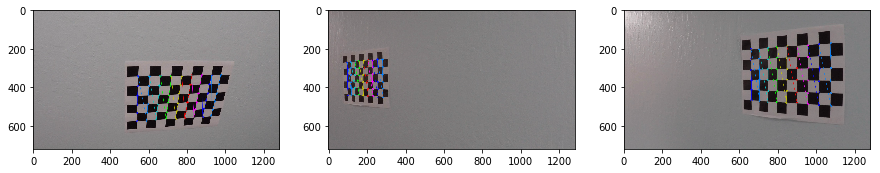

In [13]:
import glob
import ntpath
import itertools
%matplotlib inline

# number of rows and cols on the checkerboard
cal_rows = 6
cal_cols = 9

# prepare object points (3-dimensional), like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
cal_refpoints = np.zeros((cal_rows*cal_cols,3), np.float32)
cal_refpoints[:,:2] = np.mgrid[0:cal_rows, 0:cal_cols].T.reshape(-1,2)

# all object and image points
cal_objpoints = [] # 3d points in real world space
cal_imgpoints = [] # 2d points in image plane.

# list of calibration images
cal_images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
cal_no_checkboard_images = 3
cal_checkboard_images = []
for index, file in enumerate(cal_images):
    image = cv2.imread(file)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    returncode, corners = cv2.findChessboardCorners(gray, (cal_rows,cal_cols), None)
    # If found, add object and found image points
    if returncode == True:
        cal_objpoints.append(cal_refpoints)
        cal_imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(image, (cal_rows, cal_cols), corners, returncode)
        output_name = 'debug_images/corners_found_'+ntpath.basename(file)
        cv2.imwrite(output_name, image)
        if len(cal_checkboard_images) < cal_no_checkboard_images:
            cal_checkboard_images.append(image)
        
# Visualize undistortion
figure, plots = plt.subplots(1, cal_no_checkboard_images, figsize=(15,10))
for plot, image in itertools.zip_longest(plots, cal_checkboard_images, fillvalue=None):
    if image is not None:
        plot.imshow(image)


### Calculating & Storing Distortion Parameters

In [14]:
import pickle
%matplotlib inline

# Test undistortion on an image
cal_test_image = cv2.imread('camera_cal/calibration1.jpg')
cal_test_image_size = (cal_test_image.shape[1], cal_test_image.shape[0])

# Do camera calibration given object points and image points
cal_ret, cal_matrix, cal_dist, cal_rvecs, cal_tvecs = \
    cv2.calibrateCamera(cal_objpoints, cal_imgpoints, cal_test_image_size, None, None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
CAL_PICKLE = {"matrix": cal_matrix, "dist": cal_dist}
pickle.dump( CAL_PICKLE, open( CAL_PICKLE_FILE, "wb" ) )

### Undistortion

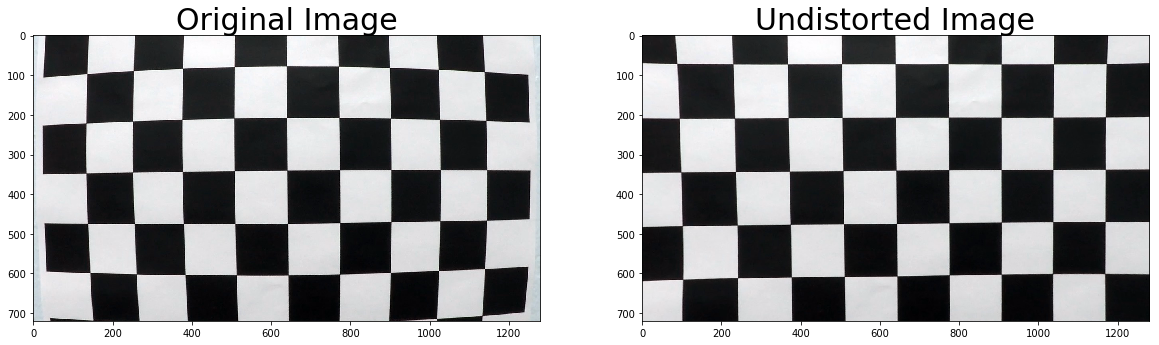

In [15]:
import pickle
%matplotlib inline

CAL_PICKLE = pickle.load(open( CAL_PICKLE_FILE, "rb" ))

def undistort(image):
    global CAL_PICKLE
    return cv2.undistort(image, CAL_PICKLE["matrix"], CAL_PICKLE["dist"], None, CAL_PICKLE["matrix"])

# Test and visualize undistortion
cal_test_image = cv2.imread(CAL_TEST_IMAGE)
cal_test_undistort = undistort(cal_test_image)
cv2.imwrite('debug_images/test_undistort.jpg',cal_test_undistort)

# Visualize undistortion
figure, (plot1, plot2) = plt.subplots(1, 2, figsize=(20,10))
plot1.imshow(cal_test_image)
plot1.set_title('Original Image', fontsize=30)
plot2.imshow(cal_test_undistort)
plot2.set_title('Undistorted Image', fontsize=30)

## Undistortion & Unwarping

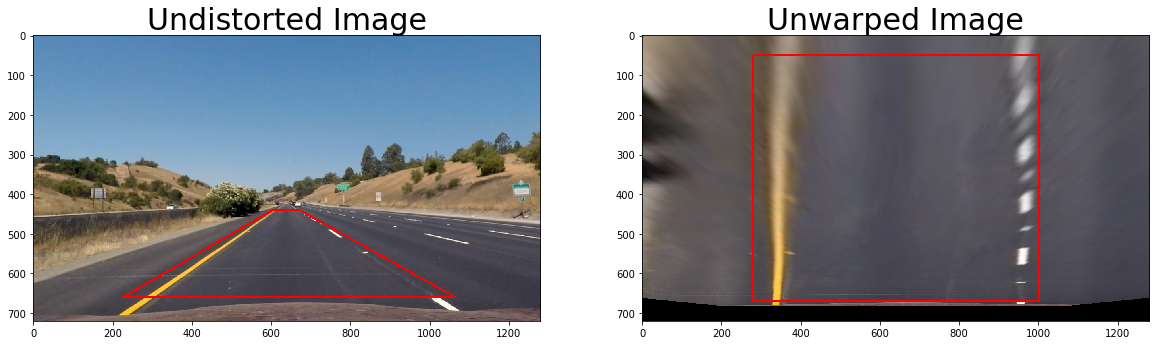

In [16]:
def show_lane_plane(image):
    global UNWARP_PLANE
    undistorted = undistort(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    color = [255,0,0]
    for (start, end) in zip([0,1,2,3], [1,2,3,0]):
        cv2.line(undistorted, UNWARP_PLANE[start], UNWARP_PLANE[end], [255,0,0], 3)
    return undistorted
    
def unwarp(image, show_plane=False):
    global UNWARP_PLANE
    global UNWARP_X_OFFSET
    global UNWARP_Y_OFFSET
    undistorted = undistort(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    source = UNWARP_PLANE
    x_offset = UNWARP_X_OFFSET 
    y_offset = UNWARP_Y_OFFSET 
    dim = (gray.shape[1], gray.shape[0])
    dest = [(x_offset, y_offset), (dim[0]-x_offset, y_offset), 
            (dim[0]-x_offset, dim[1]-y_offset), (x_offset, dim[1]-y_offset)]
    transform_matrix = cv2.getPerspectiveTransform(np.float32(source), np.float32(dest))
    unwarped = cv2.warpPerspective(undistorted, transform_matrix, dim, flags=cv2.INTER_LINEAR)
    if show_plane:
        for (start, end) in zip([0,1,2,3], [1,2,3,0]):
            cv2.line(unwarped, dest[start], dest[end], [255,0,0], 3)
    return unwarped, transform_matrix

# Test and Visualize Unwarping
figure, plots = plt.subplots(1, 2, figsize=(20,10))
unwarp_test_image = cv2.imread(UNWARP_TEST_IMAGE)
plots[0].imshow(show_lane_plane(unwarp_test_image))
plots[0].set_title('Undistorted Image', fontsize=30)
plots[1].imshow(unwarp(unwarp_test_image, show_plane=True)[0])
plots[1].set_title('Unwarped Image', fontsize=30)


## Identifying Lane Line Pixels

### Color & Gradient Threshold

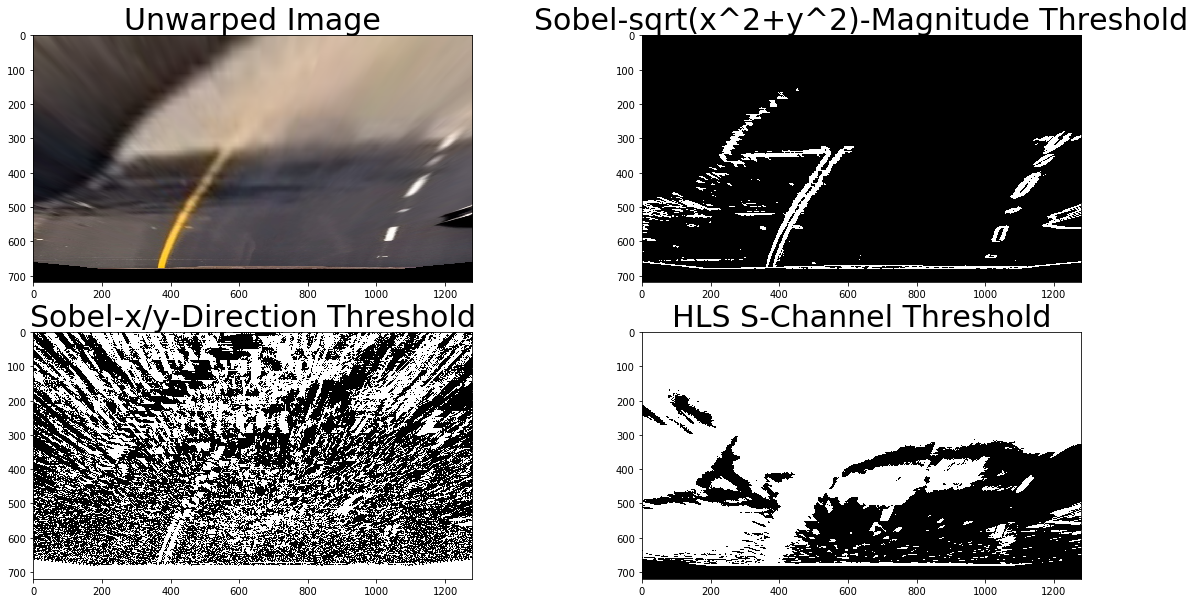

In [17]:
# applies Sobel x and y, then computes the magnitude of the gradient and applies a threshold
def mag_threshold(image, sobel_kernel=5, mag_thresh=(0, 255)):
    unwarped = unwarp(image)[0]
    # Convert to grayscale
    gray = cv2.cvtColor(unwarped, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the magnitude 
    grad_mag = np.sqrt(sobel_x**2 + sobel_y**2)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(grad_mag)/255 
    grad_mag = (grad_mag/scale_factor).astype(np.uint8) 
    # Create a binary mask where mag thresholds are met
    mask = np.zeros_like(grad_mag)
    mask[(grad_mag >= mag_thresh[0]) & (grad_mag <= mag_thresh[1])] = 1
    # Return this mask as your binary_output image
    return mask

# applies Sobel x and y, then computes the direction of the gradient and applies a threshold.
def dir_threshold(image, sobel_kernel=5, thresh=(0, np.pi/2)):
    unwarped = unwarp(image)[0]
    # Convert to grayscale
    gray = cv2.cvtColor(unwarped, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    # Create a binary mask where direction thresholds are met
    mask =  np.zeros_like(direction)
    mask[(direction < thresh[0]) | (direction > thresh[1])] = 1
    # Return this mask as your binary_output image
    return mask

# thresholds the S-channel of HLS; use exclusive lower bound (>) and inclusive upper (<=)
def s_threshold(img, thresh=(0, 255)):
    unwarped = unwarp(img)[0]
    # Convert to HLS color space
    hls = cv2.cvtColor(unwarped, cv2.COLOR_RGB2HLS)
    # Apply a threshold to the S channel
    s = hls[:,:,2]
    mask = np.zeros_like(s)
    mask[(s >= thresh[0]) & (s <= thresh[1])] = 1
    # Return a binary image of threshold result
    return mask

# Test and Visualize Different thresholds
thresh_test_image = cv2.imread(THRESH_TEST_IMAGE)
figure, plots = plt.subplots(2, 2, figsize=(20,10))
plots[0,0].imshow(unwarp(thresh_test_image)[0])
plots[0,0].set_title('Unwarped Image', fontsize=30)
plots[0,1].imshow(mag_threshold(thresh_test_image, mag_thresh=THRESH_MAG), cmap='gray')
plots[0,1].set_title('Sobel-sqrt(x^2+y^2)-Magnitude Threshold', fontsize=30)
plots[1,0].imshow(dir_threshold(thresh_test_image, thresh=THRESH_DIR), cmap='gray')
plots[1,0].set_title('Sobel-x/y-Direction Threshold', fontsize=30)
plots[1,1].imshow(s_threshold(thresh_test_image, thresh=THRESH_S), cmap='gray')
plots[1,1].set_title('HLS S-Channel Threshold', fontsize=30)


### Combining Filters

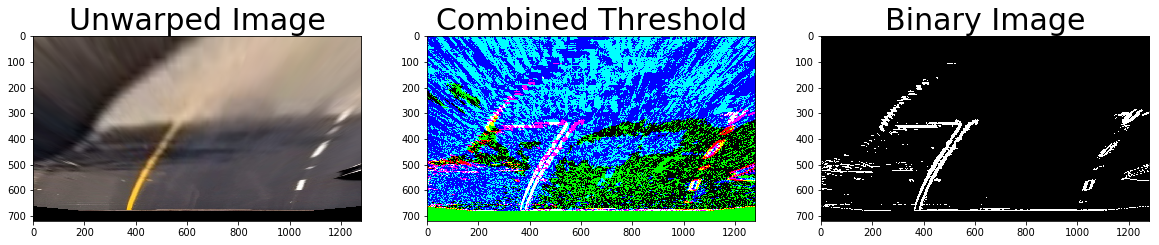

In [18]:
def combined_threshold(image):
    global THRESH_MAG
    global THRESH_DIR
    global THRESH_S
    m = mag_threshold(image, mag_thresh=THRESH_MAG)
    d = dir_threshold(image, thresh=THRESH_DIR)
    s = s_threshold(image, thresh=THRESH_S)
    color_binary = np.dstack((m, d, s))
    return color_binary

def find_lane_line_pixels(image):
    combined = combined_threshold(image)
    m = combined[:,:,0].astype(int)
    d = combined[:,:,1].astype(int)
    s = combined[:,:,2].astype(int)
    # Require that at least two filters score
    binary = (m&s)|(m&d)#|(s&d)
    #binary = m & (s | d)
    return binary.astype(float)

# Test and Visualize Combined thresholds
thresh_test_image = cv2.imread(THRESH_TEST_IMAGE)
figure, plots = plt.subplots(1, 3, figsize=(20,10))
plots[0].imshow(unwarp(thresh_test_image)[0])
plots[0].set_title('Unwarped Image', fontsize=30)
plots[1].imshow(combined_threshold(thresh_test_image))
plots[1].set_title('Combined Threshold', fontsize=30)
plots[2].imshow(find_lane_line_pixels(thresh_test_image), cmap='gray')
plots[2].set_title('Binary Image', fontsize=30)


## Lane Line Detection

### Finding Lane Line Base

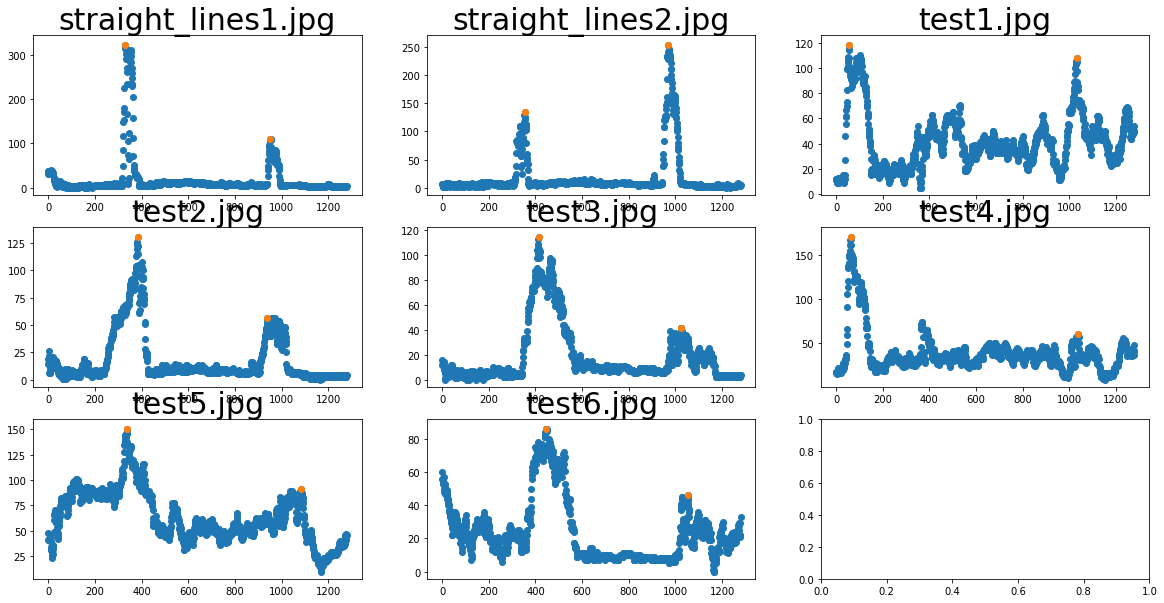

In [19]:
def halfhist(image):
    return np.sum(image[image.shape[0]//2:,:], axis=0)

def find_peaks(histogram):
    centerx = np.int(histogram.shape[0]/2)
    leftx_max = np.argmax(histogram[:centerx])
    rightx_max = np.argmax(histogram[centerx:]) + centerx
    return leftx_max, rightx_max

def find_base(lane_line_pixels):
    histogram = halfhist(lane_line_pixels)
    leftx_max, rightx_max = find_peaks(histogram)
    histogram_xs_ys = (range(0, len(histogram)), histogram)
    max_xs_ys = ([leftx_max, rightx_max], [histogram[leftx_max], histogram[rightx_max]])
    return [histogram_xs_ys, max_xs_ys]

def find_base_test(image):
    lane_line_pixels = find_lane_line_pixels(image)
    return find_base(lane_line_pixels)

run_all_test_images(find_base_test, output='multiscatter')


### Sliding Window Search

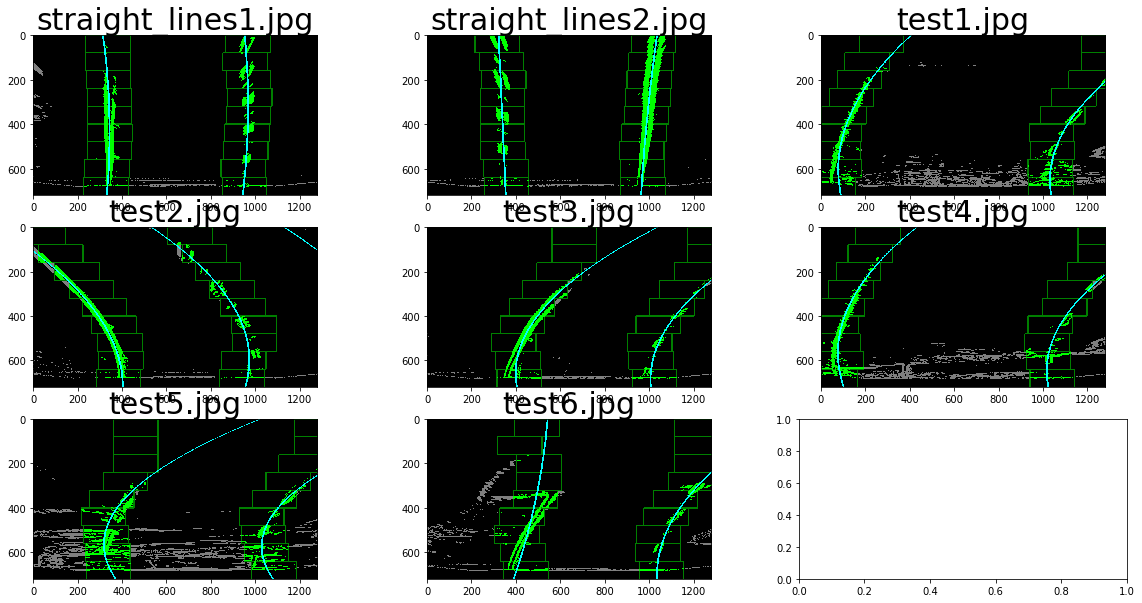

In [21]:
# nwindows = number of sliding windows
# wmargin = Set the width of the windows +/- margin
# minpix = minimum number of pixels found to recenter window
def slidewindow_search(image, nwindows=9, wmargin=100, minpix=50):
    # preprocess image and find base line pixels
    lane_line_img = find_lane_line_pixels(image)
    _, max_xs_ys = find_base(lane_line_img)
    leftx_base  = max_xs_ys[0][0]
    rightx_base = max_xs_ys[0][1]
    wheight = np.int(lane_line_img.shape[0]/nwindows)
    # Output image
    out_img = np.dstack((lane_line_img*.5, lane_line_img*.5, lane_line_img*.5))
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = lane_line_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_now = leftx_base
    rightx_now = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_idxs = []
    right_idxs = []
    # Step through sliding windows
    for w in range(nwindows):
        # Identify sliding windows
        w_y_lo = lane_line_img.shape[0] - (w+1)*wheight
        w_y_hi = lane_line_img.shape[0] - w*wheight
        w_xleft_lo = leftx_now - wmargin
        w_xleft_hi = leftx_now + wmargin
        w_xright_lo = rightx_now - wmargin
        w_xright_hi = rightx_now + wmargin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(w_xleft_lo,w_y_lo),(w_xleft_hi,w_y_hi),(0.,0.5,0.), 4) 
        cv2.rectangle(out_img,(w_xright_lo,w_y_lo),(w_xright_hi,w_y_hi),(0.,0.5,0.), 4) 
        # Identify the nonzero pixels in x and y within the window
        w_left_idxs = ((nonzeroy >= w_y_lo) & (nonzeroy < w_y_hi) & (nonzerox >= w_xleft_lo) & (nonzerox < w_xleft_hi)).nonzero()[0]
        w_right_idxs = ((nonzeroy >= w_y_lo) & (nonzeroy < w_y_hi) & (nonzerox >= w_xright_lo) & (nonzerox < w_xright_hi)).nonzero()[0]
        # Append indices to the lists
        left_idxs.extend(w_left_idxs)
        right_idxs.extend(w_right_idxs)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(w_left_idxs) > minpix:
            leftx_now = np.int(np.mean(nonzerox[w_left_idxs]))
        if len(w_right_idxs) > minpix:        
            rightx_now = np.int(np.mean(nonzerox[w_right_idxs]))
    # Extract left and right line pixel positions
    left_xs = nonzerox[left_idxs]
    left_ys = nonzeroy[left_idxs]
    right_xs = nonzerox[right_idxs]
    right_ys = nonzeroy[right_idxs] 
    # Fit a second order polynomial to each
    left_poly = np.polyfit(left_ys, left_xs, 2, full=True)
    right_poly = np.polyfit(right_ys, right_xs, 2, full=True)
    left_fit, left_err = left_poly[0], left_poly[1]
    right_fit, right_err = right_poly[0], right_poly[1]
    # visualize for debug purposes
    out_img[nonzeroy[left_idxs], nonzerox[left_idxs]] = [0., 1., 0.]
    out_img[nonzeroy[right_idxs], nonzerox[right_idxs]] = [0., 1., 0.]
    fit_ys = np.linspace(0, lane_line_img.shape[0]-1, lane_line_img.shape[0] )
    left_fit_xs = left_fit[0]*fit_ys**2 + left_fit[1]*fit_ys + left_fit[2]
    right_fit_xs = right_fit[0]*fit_ys**2 + right_fit[1]*fit_ys + right_fit[2]
    for y, left_x, right_x in zip(fit_ys, left_fit_xs, right_fit_xs):
        out_img[int(y), int(left_x-4):int(left_x+4)] = [0., 1., 1.]
        out_img[int(y), int(right_x-4):int(right_x+4)] = [0., 1., 1.]
    return (left_poly, right_poly), out_img
    
def slidewindow_and_plot(image):
    _, out_img = slidewindow_search(image)
    return out_img
    
run_all_test_images(slidewindow_and_plot)


### Proximity Search

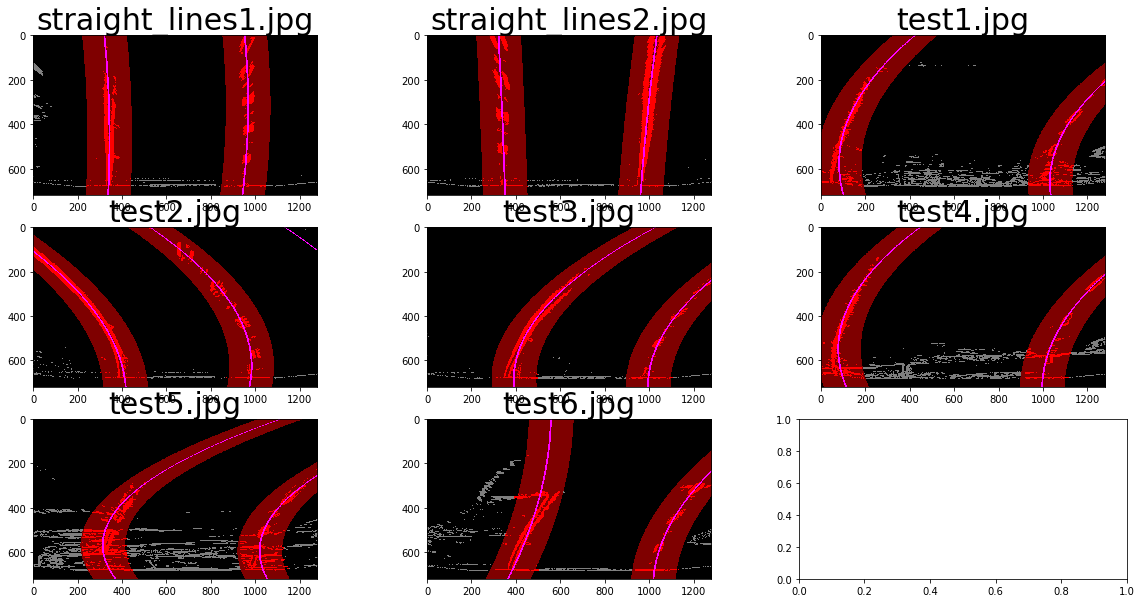

In [22]:
def proximity_search(image, old_fits, pmargin=100):
    left_fit, right_fit = old_fits
    lane_line_img = find_lane_line_pixels(image)
    nonzero = lane_line_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_idxs = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - pmargin)) & \
                 (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + pmargin))) 
    right_idxs = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - pmargin)) & \
                  (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + pmargin)))  
    # Again, extract left and right line pixel positions
    left_xs = nonzerox[left_idxs]
    left_ys = nonzeroy[left_idxs] 
    right_xs = nonzerox[right_idxs]
    right_ys = nonzeroy[right_idxs]
    # Fit a second order polynomial to each
    left_poly = np.polyfit(left_ys, left_xs, 2, full=True)
    right_poly = np.polyfit(right_ys, right_xs, 2, full=True)
    left_fit, left_err = left_poly[0], left_poly[1]
    right_fit, right_err = right_poly[0], right_poly[1]
    # visualize for debug purposes
    out_img = np.dstack((lane_line_img, lane_line_img, lane_line_img))
    window_img = np.zeros_like(out_img)
    # Generate x and y values for plotting
    fit_ys = np.linspace(0, lane_line_img.shape[0]-1, lane_line_img.shape[0] )
    left_fit_xs = left_fit[0]*fit_ys**2 + left_fit[1]*fit_ys + left_fit[2]
    right_fit_xs = right_fit[0]*fit_ys**2 + right_fit[1]*fit_ys + right_fit[2]    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_window_1 = np.array([np.transpose(np.vstack([left_fit_xs-pmargin, fit_ys]))])
    left_window_2 = np.array([np.flipud(np.transpose(np.vstack([left_fit_xs+pmargin, fit_ys])))])
    left_line_pts = np.hstack((left_window_1, left_window_2))
    right_window_1 = np.array([np.transpose(np.vstack([right_fit_xs-pmargin, fit_ys]))])
    right_window_2 = np.array([np.flipud(np.transpose(np.vstack([right_fit_xs+pmargin, fit_ys])))])
    right_line_pts = np.hstack((right_window_1, right_window_2))
    # Red: Draw the lane onto the warped blank image
    out_img = np.dstack((lane_line_img*.5, lane_line_img*.5, lane_line_img*.5))
    cv2.fillPoly(out_img, np.int_([left_line_pts]), (0.5, 0., 0.))
    cv2.fillPoly(out_img, np.int_([right_line_pts]), (0.5, 0., 0.))
    # Red: Color in left and right line pixels
    out_img[nonzeroy[right_idxs], nonzerox[right_idxs]] = [1., 0., 0.]
    out_img[nonzeroy[left_idxs], nonzerox[left_idxs]] = [1., 0., 0.]
    # Magenta: Plot polygon
    for y, left_x, right_x in zip(fit_ys, left_fit_xs, right_fit_xs):
        out_img[int(y), int(left_x-4):int(left_x+4)] = [1., 0., 1.]
        out_img[int(y), int(right_x-4):int(right_x+4)] = [1., 0., 1.]
    # Return polynoms + output image
    return (left_poly, right_poly), out_img

def proximity_and_plot(image):
    # simple slide window search first to get estimate for polygon
    old_polys, _ = slidewindow_search(image)
    # then do proximity search on same image
    _, out_img = proximity_search(image, (old_polys[0][0], old_polys[1][0]))
    return out_img
    
run_all_test_images(proximity_and_plot)


### Combining Both Search Strategies

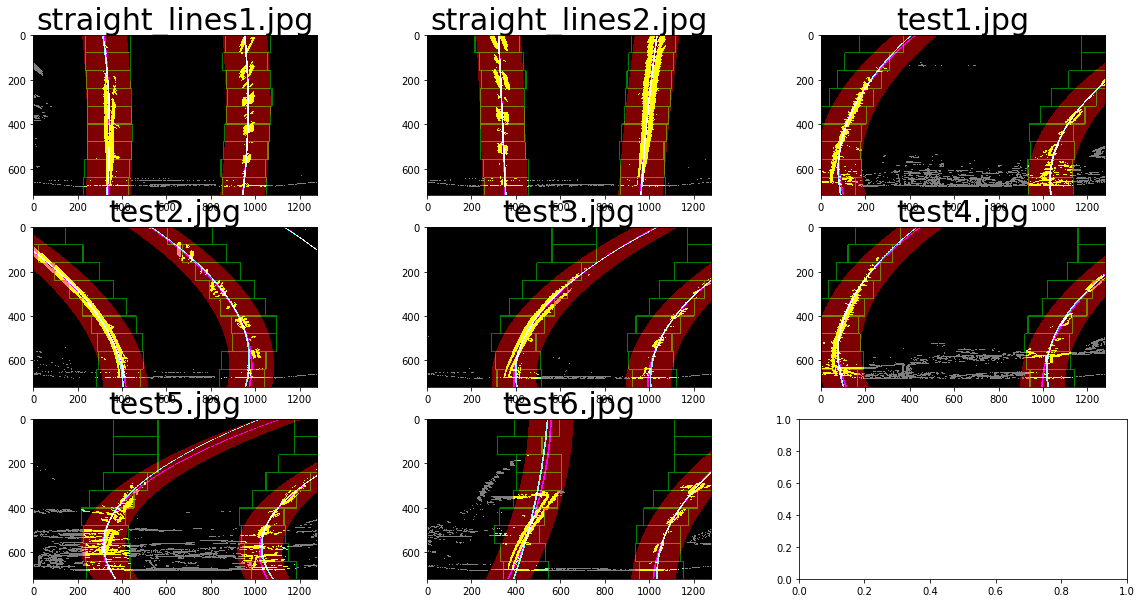

In [23]:
def combined_search(image, old_polys, fallback_threshold=1000):
    slidewindow_polys, slidewindow_img = slidewindow_search(image)
    proximity_polys, proximity_img = proximity_search(image, (old_polys[0][0], old_polys[1][0]))
    left_fit = slidewindow_polys[0][0] if proximity_polys[0][1] > fallback_threshold else proximity_polys[0][0]
    right_fit = slidewindow_polys[1][0] if proximity_polys[1][1] > fallback_threshold else proximity_polys[1][0]
    out_img = np.maximum(slidewindow_img, proximity_img)
    return (left_fit, right_fit), out_img

def combined_and_plot(image):
    # simple slide window search first to get estimate for polygon
    old_polys, _ = slidewindow_search(image)
    # then do proximity search on same image
    _, out_img = combined_search(image, old_polys)
    return out_img
    
run_all_test_images(combined_and_plot)
